## BigQuery Vector Search

* In this notebook, we are utilizing BigQuery Vector search to look for apps providing similar functionalities across all platforms - google, windows, apple.

* The search result is then submitted to the LLM to evaluate and provide improvement plans / Recommandations for our own Apps / Products to stand a market leader.


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/smvinodkumar910/market-mirror/blob/main/backend/05_competitor_apps.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fsmvinodkumar910%2Fmarket-mirror%2Frefs%2Fheads%2Fmain%2Fbackend%2F05_competitor_apps.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/smvinodkumar910/market-mirror/refs/heads/main/backend/05_competitor_apps.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://github.com/smvinodkumar910/market-mirror/blob/main/backend/05_competitor_apps.ipynb">
      <img width="32px" src="https://www.svgrepo.com/download/475654/github-color.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment.

In [2]:
import sys

if "google.colab" in sys.modules:
    # Support for third party widgets
    from google.colab import auth, output

    auth.authenticate_user()
    output.enable_custom_widget_manager()

### Setting-up Environment

* Please change the variables `PROJECT_ID`, `BUCKET_NAME`, `LOCATION` details to your own project as required.

In [3]:
import os

PROJECT_ID = "market-mirror-dev"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
BUCKET_NAME = "marke-mirror-dev-data"  # @param {type: "string", placeholder: "[your-bucket-name]", isTemplate: true}
LOCATION = "US"  # @param {type: "string", placeholder: "[your-region]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

if not LOCATION or LOCATION == "[your-region]":
    LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "US")


In [4]:
os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT_ID
os.environ['GOOGLE_CLOUD_REGION'] = LOCATION

os.environ["GOOGLE_GENAI_USE_VERTEXAI"]="true"
os.environ["GOOGLE_GENAI_LOCATION"] = LOCATION

In [5]:
BQ_BRONZE_DATASET = "APP_MARKET_BRONZE" # @param {type: "string", placeholder: "[bronze-dataset]", isTemplate: true}
BQ_SILVER_DATASET = "APP_MARKET_SILVER" # @param {type: "string", placeholder: "[silver-dataset]", isTemplate: true}
BQ_GOLD_DATASET = "APP_MARKET_GOLD" # @param {type: "string", placeholder: "[gold-dataset]", isTemplate: true}

In [6]:
google_apps_embed_tb = 'T_GOOGLE_APP_DESC_EMBEDDED'
apple_apps_embed_tb = 'T_APPLE_APP_DESC_EMBEDDED'
windows_apps_embed_tb = 'T_WINDOWS_APP_DESC_EMBEDDED'

In [11]:
from langchain_google_vertexai import ChatVertexAI

In [12]:
llm = ChatVertexAI(model='gemini-2.0-flash-001')

In [14]:
llm.invoke('Hi, how are you, my  name is Vinod')

AIMessage(content="Hi Vinod, I'm doing well, thank you for asking! It's nice to meet you. How can I help you today?\n", additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 12, 'candidates_token_count': 31, 'total_token_count': 43, 'prompt_tokens_details': [{'modality': 1, 'token_count': 12}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 31}], 'thoughts_token_count': 0, 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.1867169410951676, 'model_name': 'gemini-2.0-flash-001'}, id='run--fd8f9b31-44e7-46d5-a347-e82b7fadcdba-0', usage_metadata={'input_tokens': 12, 'output_tokens': 31, 'total_tokens': 43, 'input_token_details': {'cache_read': 0}})

In [15]:
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_google_community import BigQueryVectorStore
from google.cloud import bigquery
from langchain_google_vertexai import ChatVertexAI


from langgraph.graph import START, StateGraph, END
from langgraph.graph.message import add_messages

from pydantic import BaseModel

#Creating llm object
llm = ChatVertexAI(model='gemini-2.0-flash-001')

# Defining a custom state object to hold
class CustomState(BaseModel):
    messages: str
    query_vector: list | None = []
    top_k: int | None = 3
    google_apps_list: str | None = ''
    windows_apps_list: str | None = ''
    apple_apps_list: str | None = ''
    google_app_desc: list[dict] | None = []
    windows_app_desc: list[dict] | None = []
    apple_app_desc: list[dict] | None = []
    summary: str | None = ''


#creating embedding object
embedding = VertexAIEmbeddings(
    model_name="text-embedding-005", project=PROJECT_ID
)

#Createing BigQueryVectorStore for each table separately
#Google vector store
google_apps_vector_store = BigQueryVectorStore(
    project_id=PROJECT_ID,
    dataset_name=BQ_GOLD_DATASET,
    table_name=google_apps_embed_tb,
    location=LOCATION,
    embedding=embedding,
)

#Apple vector store
apple_apps_vector_store = BigQueryVectorStore(
    project_id=PROJECT_ID,
    dataset_name=BQ_GOLD_DATASET,
    table_name=apple_apps_embed_tb,
    location=LOCATION,
    embedding=embedding,
)

#Windows vector store
windows_apps_vector_store = BigQueryVectorStore(
    project_id=PROJECT_ID,
    dataset_name=BQ_GOLD_DATASET,
    table_name=windows_apps_embed_tb,
    location=LOCATION,
    embedding=embedding,
)


def generate_embeddings(state: CustomState):
  embeddings_list = embedding.embed_query(state.messages)
  return {'query_vector': embeddings_list}


def make_vector_search(store,platform):
  def get_similar_apps(state: CustomState):
    top_k = state.top_k
    query_vector = state.query_vector
    docs = store.similarity_search_by_vector(embedding=query_vector, k=top_k)
    similar_apps = []
    for doc in docs:
      similar_apps.append(doc.page_content)
    apps_list_str = ",".join([f"'{app}'" for app in similar_apps])
    return {f'{platform}_apps_list':apps_list_str}
  return get_similar_apps

google_apps_search = make_vector_search(google_apps_vector_store,'google')
apple_apps_search = make_vector_search(apple_apps_vector_store,'apple')
windows_apps_search = make_vector_search(windows_apps_vector_store,'windows')


def make_app_desc_function(table_id,platform):
  client = bigquery.Client(project=PROJECT_ID)
  def get_app_desc(state: CustomState):
    list_of_apps=''
    if platform == 'google':
      list_of_apps = state.google_apps_list
    elif platform == 'windows':
      list_of_apps = state.windows_apps_list
    elif platform == 'apple':
      list_of_apps = state.apple_apps_list
    else:
      raise ValueError('Invalid platform')

    sql_query = f"""select * from {table_id} where app_name in ({list_of_apps})"""

    df = client.query(sql_query).to_dataframe()
    output = {f'{platform}_app_desc' : df.to_dict('records')}
    return output
  return get_app_desc

get_apple_app_desc = make_app_desc_function('market-mirror-dev.APP_MARKET_GOLD.T_APPLE_APP_DETAIL_FINAL','apple')
get_windows_app_desc = make_app_desc_function('market-mirror-dev.APP_MARKET_GOLD.T_WINDOWS_APP_DETAIL_FINAL','windows')
get_google_app_desc = make_app_desc_function('market-mirror-dev.APP_MARKET_GOLD.T_GOOGLE_APP_DETAIL_FINAL','google')


def get_comparison_summary(state: CustomState):

  template = f"""
    You are a market research analyst.
    You will be provided with app details from 3 platforms - google, apple and windows.
    You have to evaluate the features of the apps, summarize them in bullet points for each app in each platform.

    Google App Details : {state.google_app_desc}
    Windows App Details : {state.windows_app_desc}
    Apple App Details : {state.apple_app_desc}
    """


  output = llm.invoke(template)

  print(output)
  return {"summary":output}



# Define a new graph
workflow = StateGraph(state_schema=CustomState)

#Create nodes
workflow.add_node("generate_query_embedding", generate_embeddings)

workflow.add_node("google_apps_search", google_apps_search)
workflow.add_node("windows_apps_search", windows_apps_search)
workflow.add_node("apple_apps_search", apple_apps_search)

workflow.add_node("get_google_app_desc", get_google_app_desc)
workflow.add_node("get_windows_app_desc", get_windows_app_desc)
workflow.add_node("get_apple_app_desc", get_apple_app_desc)

workflow.add_node("get_comparison_summary", get_comparison_summary)

#Create Edges
workflow.add_edge(START, "generate_query_embedding")

workflow.add_edge("generate_query_embedding", "google_apps_search")
workflow.add_edge("generate_query_embedding", "windows_apps_search")
workflow.add_edge("generate_query_embedding", "apple_apps_search")

workflow.add_edge("google_apps_search", "get_google_app_desc")
workflow.add_edge("windows_apps_search", "get_windows_app_desc")
workflow.add_edge("apple_apps_search", "get_apple_app_desc")

workflow.add_edge("get_google_app_desc","get_comparison_summary")
workflow.add_edge("get_windows_app_desc","get_comparison_summary")
workflow.add_edge("get_apple_app_desc","get_comparison_summary")

workflow.add_edge("get_comparison_summary", END)

app = workflow.compile()



/usr/local/lib/python3.11/dist-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
INFO:langchain_google_community.bq_storage_vectorstores._base:BigQuery table market-mirror-dev.APP_MARKET_GOLD.T_GOOGLE_APP_DESC_EMBEDDED initialized/validated as persistent storage. Access via BigQuery console:
 https://console.cloud.google.com/bigquery?project=market-mirror-dev&ws=!1m5!1m4!4m3!1smarket-mirror-dev!2sAPP_MARKET_GOLD!3sT_GOOGLE_APP_DESC_EMBEDDED
INFO:langchain_google_community.bq_storage_vectorstores._base:BigQuery table market-mirror-dev.APP_MARKET_GOLD.T_APPLE_APP_DESC_EMBEDDED initialized/validated as persistent storage. Access via BigQuery console:
 https://console.cloud.google.com/bigquery?project=market-mirror-dev&ws=!1m5!1m4!4m3!1sma

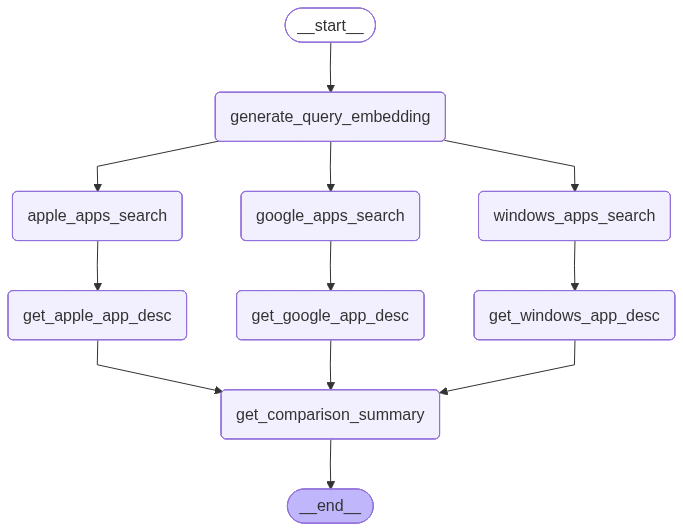

In [16]:
from IPython.display import Image, Markdown, display

display(Image(app.get_graph().draw_mermaid_png()))
#

In [17]:
output = app.invoke(input={"messages": "app for online purchasing, fast delivery with less cost"})

content='Okay, here\'s a breakdown of the app features, summarized by platform and app:\n\n**Google Play Store Apps**\n\n*   **Snoonu - Fastest Delivery (Food & Drink)**\n\n    *   Fastest delivery service in Qatar (24/7)\n    *   Offers food, groceries, retail items\n    *   Partners with restaurants for diverse cuisine options\n    *   Grocery delivery from multiple stores (Almeera, Megamart, SPAR, Snoomart)\n    *   Online shopping for pharmacy, electronics, toys, flowers, etc.\n    *   "Snoosend" point-to-point delivery service for packages\n    *   Offers & discounts\n    *   Easy in-app navigation\n    *   Real-time delivery tracking\n    *   Multiple payment methods (Apple Pay, Google Pay, Cash, Cards)\n    *   Save multiple delivery addresses\n    *   Order history & reordering\n    *   Customer support\n\n*   **Takeaway.com - Order Food (Food & Drink)**\n\n    *   Online food ordering from restaurants.\n    *   Wide variety of cuisines.\n    *   Easy ordering process.\n    *  

In [23]:
from IPython import display
display.Markdown(output['summary'].content)


Okay, here's a breakdown of the app features, summarized by platform and app:

**Google Play Store Apps**

*   **Snoonu - Fastest Delivery (Food & Drink)**

    *   Fastest delivery service in Qatar (24/7)
    *   Offers food, groceries, retail items
    *   Partners with restaurants for diverse cuisine options
    *   Grocery delivery from multiple stores (Almeera, Megamart, SPAR, Snoomart)
    *   Online shopping for pharmacy, electronics, toys, flowers, etc.
    *   "Snoosend" point-to-point delivery service for packages
    *   Offers & discounts
    *   Easy in-app navigation
    *   Real-time delivery tracking
    *   Multiple payment methods (Apple Pay, Google Pay, Cash, Cards)
    *   Save multiple delivery addresses
    *   Order history & reordering
    *   Customer support

*   **Takeaway.com - Order Food (Food & Drink)**

    *   Online food ordering from restaurants.
    *   Wide variety of cuisines.
    *   Easy ordering process.
    *   Secure payment options (Credit Card, PayPal).
    *   Option to pick up food.
    *   Food Tracker for order updates.
    *   Reordering in two steps.
    *   Filters for restaurant selection (reviews, distance, price, etc.)
    *   Map view for restaurant locations.

*   **OurShopee - Online Shopping (Shopping)**

    *   Online shopping across UAE, Oman, Qatar, Kuwait, and Bahrain
    *   Buy now pay later with Tabby (4 installments, no interest)
    *   Wide range of products including home, fashion, electronics, toys.
    *   Payment on delivery option
    *   7-day return service
    *   Customer support

**Windows Store Apps**

*   **Free Online Invoicing & Billing App - Moon Invoice (Business > Accounting & finance)**

    *   Invoice maker
    *   Free accounting solution for small and medium businesses
    *   Customized invoices with business logo
    *   End-to-end invoicing solutions (estimates, payments, track time, reports)
    *   Print or send online documents
    *   Manage multiple businesses
    *   Create unlimited invoices

*   **Flipkart (Shopping)**

    *   Online shopping app for Fashion, Electronics, Books, Mobiles and other categories.
    *   Easy Returns, 100% Buyer Protection
    *   Cash on Delivery, Credit/Debit Card, EMI, NetBanking, PayZippy
    *   Smart Search
    *   Sort and multi-filter function
    *   Personalized Alerts
    *   Product Suggestions
    *   One-touch Wishlist
    *   Offline browsing
    *   Share with Friends

*   **Dell Digital Delivery (Utilities & tools)**

    *   Download applications purchased directly from www.dell.com.
    *   Track the progress
    *   Launch the installer.

**Apple App Store Apps**

*   **DaWanda - The marketplace for unique products (Shopping)**

    *   Marketplace for handmade, DIY, and design products
    *   Browse products without registration
    *   Categories: Fashion, Jewelry, Home & Living, Baby, Vintage
    *   Curated themes and seasonal inspiration
    *   Messaging functionality for buyer-seller communication
    *   Improved product lists & categories
    *   Detailed product presentation with high-resolution images
    *   Secure shopping with payment methods like PayPal

*   **Walmart: Free 2-Day Shipping,* Easy Store Shopping (Shopping)**

    *   Free 2-Day Shipping on eligible items ($35+ order)
    *   Pickup Discount (order online, pick up in-store)
    *   Easy reordering of essential items
    *   Walmart Pay (in-store mobile payments)
    *   Prescription ordering, transfer, and tracking
    *   Faster in-store pickup with mobile check-in
    *   Notifications for weekly ads and Rollbacks
    *   Find locations, in-store inventory, aisle locations, and store hours.

*   **AliExpress Shopping App (Shopping)**

    *   Shop trending products across many categories (home, health, tech, fashion)
    *   Easy search functionality
    *   Coupons, discounts, flash deals
    *   Free shipping on most products
    *   Order management and shipment notifications
    *   Buyer Protection
    *   Personalized product feeds
    *   Multiple language and currency support

Hope this is helpful!
